# target encoder & ohe & xDeepFM - basic

In [2]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import roc_auc_score

from hyperopt import hp
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, xdeepfm, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [4]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [5]:
# for col in bin_col:
#     map_dict = dict(zip(train_df[col].unique(), [0., 1.]))
#     train_df[col] = train_df[col].map(map_dict)
#     test_df[col] = test_df[col].map(map_dict)

In [6]:
ecd = IdxValEncoder(feature_col, bin_col=bin_col, class_col=class_col)
ecd.fit(train_df, verbose=1)

600000it [00:17, 33655.19it/s]


In [7]:
ecd.fit(test_df, verbose=1)

400000it [00:12, 32856.38it/s]


In [8]:
idx, val = ecd.transform(train_df, verbose=1)
idx_test, val_test = ecd.transform(test_df, verbose=1)

600000it [00:19, 30328.46it/s]
400000it [00:12, 30912.41it/s]


# Search Max LR

In [15]:
%%time

tf.keras.backend.clear_session()

batch_size = 8192
epochs = 5
nflold = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy', 
               'use_linear': False,
               'use_deep': False,
               'use_cin': True,
               'num_cin_layer': 4, 'num_cin_size': 256,
               'split_half':True}

mf = MaxLrFinder(1e-6, 1e-1, epochs=epochs, batch_size=batch_size, sample_length=train_df.shape[0]*((nflold-1)/nflold))
fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[mf], 'workers': 16}

model = xdeepfm(**model_param)

cv = CV(model, nflold)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)


Train on 479999 samples, validate on 120001 samples
Epoch 1/5
479999/479999 [==============================] - 16s 33us/sample - loss: 0.6898 - AUC: 0.4985 - val_loss: 0.6819 - val_AUC: 0.4999
Epoch 2/5
479999/479999 [==============================] - 10s 21us/sample - loss: 0.6481 - AUC: 0.5004 - val_loss: 0.5764 - val_AUC: 0.5309
Epoch 3/5
479999/479999 [==============================] - 10s 21us/sample - loss: 0.4855 - AUC: 0.5741 - val_loss: 0.4189 - val_AUC: 0.7512
Epoch 4/5
479999/479999 [==============================] - 10s 21us/sample - loss: 0.4013 - AUC: 0.7801 - val_loss: 0.4009 - val_AUC: 0.7811
Epoch 5/5
479999/479999 [==============================] - 10s 21us/sample - loss: 99750688.1423 - AUC: 0.5806 - val_loss: 686614219.5412 - val_AUC: 0.4912
folds 0 is done, score is 0.4911891690990009
Train on 479999 samples, validate on 120001 samples
Epoch 1/5
479999/479999 [==============================] - 12s 25us/sample - loss: 0.6833 - AUC: 0.4983 - val_loss: 0.6637 - val_AU

In [16]:
tf.keras.backend.clear_session()

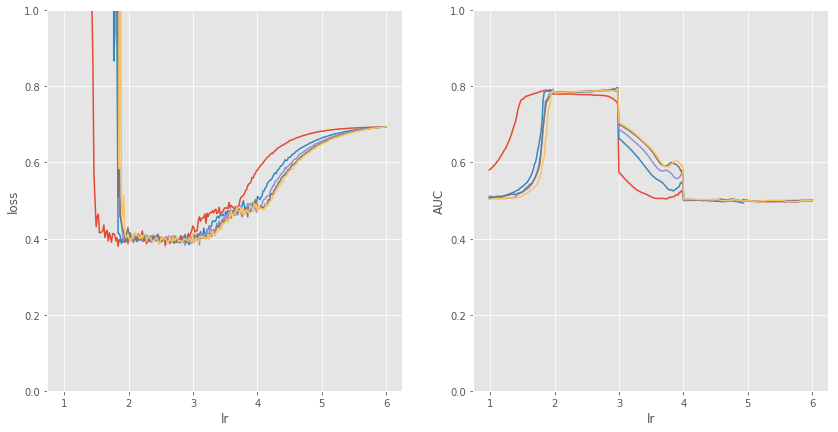

In [18]:
mf.plot(True, lim=[0, 1])

# fit one

In [21]:
%%time

batch_size = 8192
epochs = 100
nflod = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy',
               'use_linear': False,
               'use_deep': False,
               'use_cin': True}

clr = CyclicLR(base_lr=1e-5,
               max_lr=1e-3, 
               step_size=int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, mode='max', restore_best_weights=True)

fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[es, clr]}

model = xdeepfm(**model_param)

cv = CV(model, nflod)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 479999 samples, validate on 120001 samples
Epoch 1/100
479999/479999 [==============================] - 5s 11us/sample - loss: 0.6305 - AUC: 0.5000 - val_loss: 0.5242 - val_AUC: 0.5399
Epoch 2/100
479999/479999 [==============================] - 3s 7us/sample - loss: 0.4781 - AUC: 0.5861 - val_loss: 0.4483 - val_AUC: 0.7340
Epoch 3/100
479999/479999 [==============================] - 3s 7us/sample - loss: 0.4101 - AUC: 0.7674 - val_loss: 0.3980 - val_AUC: 0.7848
Epoch 4/100
479999/479999 [==============================] - 3s 7us/sample - loss: 0.3919 - AUC: 0.7938 - val_loss: 0.3968 - val_AUC: 0.7869
Epoch 5/100
479999/479999 [==============================] - 3s 7us/sample - loss: 0.3895 - AUC: 0.7972 - val_loss: 0.3971 - val_AUC: 0.7864
Epoch 6/100
479999/479999 [==============================] - 3s 7us/sample - loss: 0.3879 - AUC: 0.7993 - val_loss: 0.3976 - val_AUC: 0.7861
Epoch 7/100
479999/479999 [==============================] - 3s 7us/sample - loss: 0.3867 - AUC: 0.80

In [22]:
score

0.7877051569054266

# Tuning

In [ ]:
batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=1e-5,
               max_lr = 1e-3, 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=2,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam',
                   'use_linear': False,
                   'use_deep': False,
                   'use_cin': True, 
                   'k': 5}

ss = {
    'loss': (hp.choice, ('focal_loss', 'binary_crossentropy')), 
    'num_cin_layer': (hp.choice, (1, 2, 3, 4)),
    'num_cin_size': (hp.choice, (32, 64, 128, 256)),
    'cin_activation': (hp.choice, ('mish', 'gelu', 'linear', 'relu')),
    'l2_cin': (hp.loguniform, (-20, 0)),
    'l2_pair': (hp.loguniform, (-20, 0)),
    'cin_dropout': (hp.uniform, (0., 0.5))
}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=xdeepfm, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

new best, eval 1, score -0.6196, param {'cin_activation': 'relu', 'cin_dropout': 0.41943913044678, 'l2_cin': 0.2474163272016758, 'l2_pair': 5.8640679331547826e-09, 'loss': 'binary_crossentropy', 'num_cin_layer': 4, 'num_cin_size': 64}
new best, eval 2, score -0.7871, param {'cin_activation': 'relu', 'cin_dropout': 0.42866652715232867, 'l2_cin': 0.002535009894349025, 'l2_pair': 2.78515247391503e-05, 'loss': 'binary_crossentropy', 'num_cin_layer': 1, 'num_cin_size': 128}
new best, eval 3, score -0.7877, param {'cin_activation': 'mish', 'cin_dropout': 0.24610454750119565, 'l2_cin': 0.0015095265873823595, 'l2_pair': 5.6164992038370736e-08, 'loss': 'binary_crossentropy', 'num_cin_layer': 3, 'num_cin_size': 32}
new best, eval 7, score -0.7884, param {'cin_activation': 'gelu', 'cin_dropout': 0.007588570259166039, 'l2_cin': 1.5461542262682648e-08, 'l2_pair': 9.84780463033403e-05, 'loss': 'focal_loss', 'num_cin_layer': 2, 'num_cin_size': 256}
new best, eval 11, score -0.7885, param {'cin_activa

# Stacking

In [30]:
log = tuning.log.get_log()

In [35]:
seed = np.random.randint(2**32)
print(seed)

1960993645


### 1960993645

In [36]:
######
log.to_csv(f'/data/{seed}.csv', index=False)
#####

In [37]:
batch_size = 8192
epochs = 400
nflod = 40
nmodel = 5

In [38]:
# model params
model_tuning_param = log.sort_values('score').head(nmodel).reset_index(drop=True).to_dict()

model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam',
                   'use_linear': False,
                   'use_deep': False,
                   'use_cin': True, 
                   'k': 5}

In [39]:
# callbacks
clr = CyclicLR(
    base_lr=0.1**(5),
    max_lr = 0.1**(3.5), 
    step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
    mode='triangular2',
    gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

# fit
fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

In [41]:
pred_lst = []
score_lst = []
pred_arr_lst = []

for i in range(nmodel):
    model_params = {}
    for param_name, param_value in model_fix_param.items():
        model_params[param_name] = param_value
        
    for param_name in model_tuning_param.keys():
        if param_name not in ['score', 'update', 'usetime', 'index']:
            model_params[param_name] = model_tuning_param[param_name][i]
            
    # cv
    model = xdeepfm(**model_params)
    cv = CV(model, nflod)
    
    score, pred_arr = cv.fit(x=[idx, val],
                             y=y_train, 
                             metrics_func=roc_auc_score,
                             split_method=StratifiedKFold,
                             fit_params=fit_param,
                             eval_param={'batch_size':batch_size},
                             use_proba=False, 
                             verbose=True,
                             fit_use_valid=True,
                             output_oof_pred=True)
    
    pred = cv.predict(x=[idx_test, val_test], pred_param={'batch_size': batch_size})
    
    pred_lst.append(pred)
    score_lst.append(score)
    pred_arr_lst.append(pred_arr)
    
    print('score: ', score)
    del model, cv
    tf.keras.backend.clear_session()

folds 0 is done, score is 0.787444527059162
folds 1 is done, score is 0.7867683283203876
folds 2 is done, score is 0.7847381991377546
folds 3 is done, score is 0.7939158471577272
folds 4 is done, score is 0.7874547511655862
folds 5 is done, score is 0.7896620448652518
folds 6 is done, score is 0.7812161312868744
folds 7 is done, score is 0.797122523479971
folds 8 is done, score is 0.7837239057557709
folds 9 is done, score is 0.7858604388193462
folds 10 is done, score is 0.791296316158931
folds 11 is done, score is 0.784977106560932
folds 12 is done, score is 0.7854727231111336
folds 13 is done, score is 0.792888788290486
folds 14 is done, score is 0.795085668711817
folds 15 is done, score is 0.7933386185467468
folds 16 is done, score is 0.7955319791923712
folds 17 is done, score is 0.7895506388524351
folds 18 is done, score is 0.7863281600517084
folds 19 is done, score is 0.7891626602564102
folds 20 is done, score is 0.7859381075629435
folds 21 is done, score is 0.7875886779009729
fold

folds 19 is done, score is 0.7891007793864175
folds 20 is done, score is 0.7860232832140641
folds 21 is done, score is 0.7881461022967748
folds 22 is done, score is 0.7838103812410735
folds 23 is done, score is 0.7905322765476965
folds 24 is done, score is 0.7915233782041935
folds 25 is done, score is 0.790564976870546
folds 26 is done, score is 0.789904120725561
folds 27 is done, score is 0.794137636841869
folds 28 is done, score is 0.7852503200220967
folds 29 is done, score is 0.7900035945526841
folds 30 is done, score is 0.7922084638425271
folds 31 is done, score is 0.7917611310204813
folds 32 is done, score is 0.7835168523939848
folds 33 is done, score is 0.797194832233177
folds 34 is done, score is 0.7875933952767122
folds 35 is done, score is 0.7825092764345963
folds 36 is done, score is 0.7863305406468957
folds 37 is done, score is 0.8006847649975777
folds 38 is done, score is 0.7939362756748533
folds 39 is done, score is 0.7894930487929422
score:  0.7894715884987615


In [42]:
pred_arr = np.array(pred_arr_lst).squeeze().T
np.save(f'/data/{seed}stacking1.npy', pred_arr)
pred_arr.shape

(600000, 5)

In [43]:
pred = np.array(pred_lst).squeeze().T
np.save(f'/data/{seed}predict.npy', pred)
pred.shape

(400000, 5)

In [44]:
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')
submission['target'] = np.mean(pred_lst, axis=0)
submission.to_csv(f'/data/main_4_cin_{seed}.csv')